In [33]:
import torch
from models.resnet import Resnet1D
N_CH = 8

In [34]:
x = torch.randn(1, 20, 100) # (batch_size, length, channels)
resnet = Resnet1D(n_in = 20, n_depth=3, dilation_growth_rate=1)

out = resnet(x)
print(out.shape) # (1, 20, 5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using  device: {device}")

torch.Size([1, 20, 100])
using  device: cuda


In [35]:
# count number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {count_parameters(resnet)}")

Number of parameters: 4920


In [36]:
from models.encdec import Encoder

encoder = Encoder(input_emb_width=20)
encoder(x).shape

torch.Size([1, 512, 12])

In [37]:
from models.vqvae import VQVAE_251
args = {
    "quantizer": "ema"
}
vqvae = VQVAE_251(
    args
)

In [38]:
x = torch.randn(1, 128, 20) # (batch_size, length, channels)
vqvae(x)[0].shape


torch.Size([1, 128, 20])

In [39]:
vqvae.encode(x).shape

torch.Size([1, 16])

In [40]:
import numpy as np

def generate_sine_wave_data(batch_size, time_steps, channels, split_ratio=0.8, noise_std=0.05, seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)

    # 周波数・位相をランダムにする（チャンネルごと）
    freqs = np.random.uniform(1.5, 2.0, size=(batch_size, channels))
    phases = np.random.uniform(0, 2*np.pi, size=(batch_size, channels))

    # 時間軸
    t = np.linspace(0, 2 * np.pi, time_steps)

    # データ生成
    data = []
    for b in range(batch_size):
        sample = []
        for c in range(channels):
            y = np.sin(freqs[b, c] * t + phases[b, c])
            y += np.random.normal(0, noise_std, size=y.shape)
            sample.append(y)
        sample = np.stack(sample, axis=-1)  # [Time, Channel]
        data.append(sample)

    data = np.stack(data, axis=0)  # [Batch, Time, Channel]
    data_tensor = torch.tensor(data, dtype=torch.float32)

    # Split into train / val
    split_idx = int(batch_size * split_ratio)
    train_data = data_tensor[:split_idx]
    val_data = data_tensor[split_idx:]

    return train_data, val_data

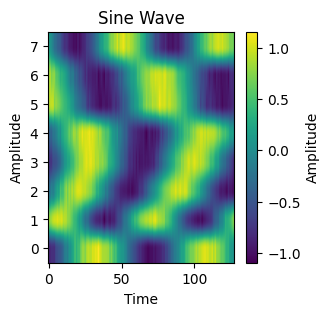

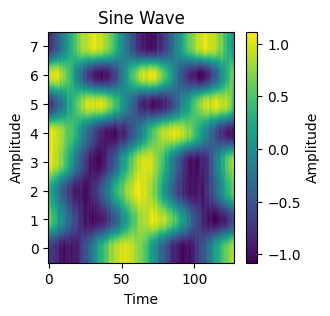

In [41]:
train, val = generate_sine_wave_data(10000, 128, N_CH, split_ratio=0.8, noise_std=0.05, seed=42)

# imshow
import matplotlib.pyplot as plt
import numpy as np
def plot_sine_wave(data, title="Sine Wave", xlabel="Time", ylabel="Amplitude"):
    # imshow
    plt.figure(figsize=(3, 3))
    plt.imshow(data, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Amplitude')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

plot_sine_wave(train[0].numpy().T, title="Sine Wave", xlabel="Time", ylabel="Amplitude")
plot_sine_wave(val[0].numpy().T, title="Sine Wave", xlabel="Time", ylabel="Amplitude")


In [42]:
args = {
    "quantizer": "ema"
}
model = VQVAE_251(
    args,
    nb_code=128,
    n_channels=N_CH
)
lossi = []

# train model
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
num_epochs = 10

model = model.to(device)  # Move the model to the device

In [43]:

def calculate_eval_loss(model, data_loader, device):
    with torch.no_grad():
        total_loss = 0
        for batch in data_loader:
            x = batch[0].to(device)
            x_out, q_loss, perplexity = model(x)
            loss_recon = torch.mean((x - x_out) ** 2)
            loss = loss_recon + q_loss * 0.25
            total_loss += loss.item()
        avg_loss = total_loss / len(data_loader)
        return avg_loss

for epoch in range(num_epochs):
    steps = 0
    for batch in train_loader:
        x = batch[0].to(device)  # Move the input batch to the device
        optimizer.zero_grad()
        x_out, q_loss, perplexity = model(x)

        loss_recon = torch.mean((x - x_out) ** 2)
        loss = loss_recon + q_loss * 0.25
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
        steps += 1
        if steps % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{steps}], Loss: {loss.item():.4f}, Recon Loss: {loss_recon.item():.4f}, Quantization Loss: {q_loss.item():.4f}, Perplexity: {perplexity.item():.4f}")
            val_loss = calculate_eval_loss(model, val_loader, device)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

Epoch [1/10], Step [100], Loss: 0.3958, Recon Loss: 0.3597, Quantization Loss: 0.1444, Perplexity: 8.8612
Epoch [1/10], Validation Loss: 0.3852
Epoch [1/10], Step [200], Loss: 0.3344, Recon Loss: 0.3027, Quantization Loss: 0.1269, Perplexity: 22.9284
Epoch [1/10], Validation Loss: 0.3170
Epoch [2/10], Step [100], Loss: 0.2788, Recon Loss: 0.2635, Quantization Loss: 0.0609, Perplexity: 55.0933
Epoch [2/10], Validation Loss: 0.2842
Epoch [2/10], Step [200], Loss: 0.2780, Recon Loss: 0.2651, Quantization Loss: 0.0516, Perplexity: 74.5031
Epoch [2/10], Validation Loss: 0.2757
Epoch [3/10], Step [100], Loss: 0.2306, Recon Loss: 0.2124, Quantization Loss: 0.0731, Perplexity: 102.6529
Epoch [3/10], Validation Loss: 0.2267
Epoch [3/10], Step [200], Loss: 0.2287, Recon Loss: 0.1953, Quantization Loss: 0.1336, Perplexity: 101.5388
Epoch [3/10], Validation Loss: 0.2145
Epoch [4/10], Step [100], Loss: 0.1473, Recon Loss: 0.1006, Quantization Loss: 0.1869, Perplexity: 97.4904
Epoch [4/10], Validati

KeyboardInterrupt: 

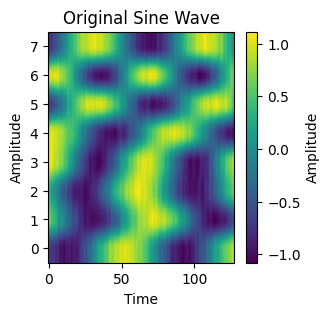

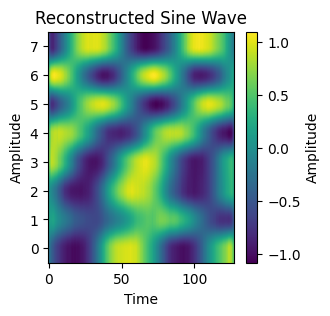

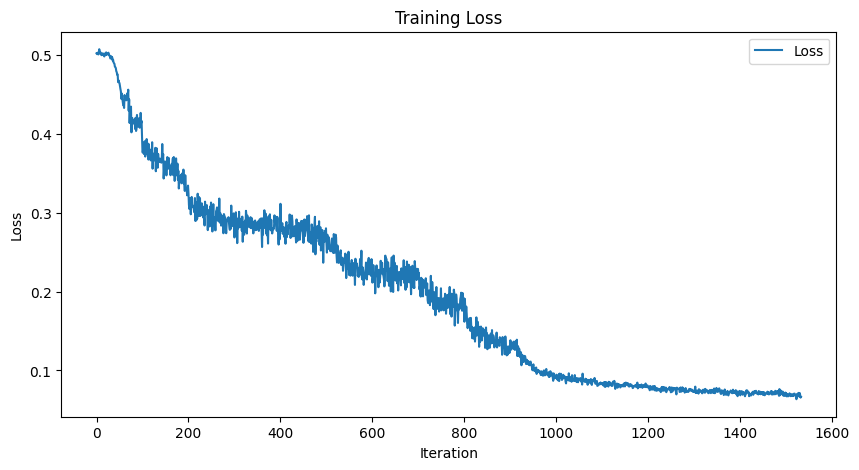

In [44]:

model.eval()
with torch.no_grad():
    recon = model(val[0:1].to(device))[0]
    plot_sine_wave(val[0].cpu().numpy().T, title="Original Sine Wave", xlabel="Time", ylabel="Amplitude")
    plot_sine_wave(recon[0].cpu().numpy().T, title="Reconstructed Sine Wave", xlabel="Time", ylabel="Amplitude")

# plot loss
plt.figure(figsize=(10, 5))
plt.plot(lossi, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [45]:
data = []

with torch.no_grad():
    for d in train_loader:
        x = d[0].to(device)
        enc = model.encode(x)
        # print(enc.shape, enc) # 32, 16 = B, tokens
        # to numpy array
        enc = enc.cpu().numpy()
        # append to data
        data.append(enc)


In [46]:
dataset = np.vstack(data)  # [Batch, Time, Channel]
print(dataset.shape)  # (32, 16)

(8000, 16)


In [47]:
# save model
torch.save(model.state_dict(), "vqvae.pth")

# save dataset
np.save("dataset.npy", dataset)

In [52]:
import math, os, time, urllib.request, torch.nn as nn, torch.nn.functional as F

# ------------------ Hyper‑parameters ------------------
batch_size   = 32        # sequences per gradient step
block_size   = 8       # context length
n_epochs     = 20        # feel free to raise
lr           = 3e-4
eval_interval = 200      # mini‑batches between loss reports
n_embd       = 384
n_heads      = 3
n_layers     = 3
dropout      = 0.2
device       = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size   = 128
torch.manual_seed(1337)
# ------------------------------------------------------
class CharacterTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.tok_emb = nn.Embedding(vocab_size, n_embd)
    self.pos_emb  = nn.Parameter(torch.randn(block_size, n_embd) / math.sqrt(n_embd))
    encoder_layer = nn.TransformerEncoderLayer(
        d_model = n_embd,
        nhead = n_heads,
        dim_feedforward = 4 * n_embd,
        dropout = dropout,
        activation = "gelu",
        batch_first = True
    )

    self.transformer = nn.TransformerEncoder(
        encoder_layer,
        num_layers = n_layers
    )

    self.lm_head = nn.Linear(n_embd, vocab_size) # logits

  def _causal_mask(self, L):
    mask = torch.triu(torch.ones(L, L, device=device), diagonal=1)
    mask = mask.masked_fill(mask==1, float("-inf"))
    return mask

  def forward(self, x, targets=None):
    B, T = x.shape
    tok_emb = self.tok_emb(x)
    pos_emb = self.pos_emb[:T, :].unsqueeze(0)
    tok = tok_emb + pos_emb

    tok_out = self.transformer(tok, mask=self._causal_mask(T))

    logits = self.lm_head(tok_out)
    loss=None

    if(targets is not None):
      B, T, C = logits.shape
      logits = logits.view(B * T, C)
      targets = targets.view(B * T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens=200, top_k=40):
    for _ in range(max_new_tokens):
      idx_cond = idx[:, -block_size:]
      logits, _ = self(idx_cond)
      logits = logits[:, -1, :] / 1.0
      topk = torch.topk(logits, k=top_k).indices
      logits = torch.full_like(logits, float("-inf")).scatter(1, topk, logits.gather(1, topk))
      probs  = F.softmax(logits, dim=-1)

      next_id = torch.multinomial(probs, num_samples=1)
      idx = torch.cat([idx, next_id], dim=1)
    return idx


In [55]:
def get_batch(data: torch.Tensor, batch_size: int, context_size: int):
    """
    data: torch.Tensor of shape (D, T)
    Returns:
        x: (batch_size, context_size)
        y: (batch_size, context_size), shifted by +1
    """
    D, T = data.shape
    x = torch.zeros((batch_size, context_size), dtype=torch.long)
    y = torch.zeros((batch_size, context_size), dtype=torch.long)

    for i in range(batch_size):
        d = torch.randint(0, D, (1,)).item()
        t = torch.randint(0, T - context_size - 1, (1,)).item()

        x[i] = data[d, t     : t + context_size]
        y[i] = data[d, t + 1 : t + context_size + 1]

    return x, y
dataset_tensor = torch.tensor(dataset, dtype=torch.long)
x,y = get_batch(dataset_tensor, batch_size=32, context_size=8)
print(x[0], y[0])  
    

tensor([100, 119,  29,  20,  82, 113,  16,  16]) tensor([119,  29,  20,  82, 113,  16,  16,  87])


In [56]:
wave_generator = CharacterTransformer()
wave_generator = wave_generator.to(device)



c:\Users\jojoj\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [ ]:
# TODO: learning rate decay from 3e-4 all the way to 1e-6
optimizer = torch.optim.AdamW(wave_generator.parameters(), lr=1e-6)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)


# --------------------- Training Loop -----------------
for epoch in range(n_epochs):
    for it in range(0, len(train), batch_size):
        x, y = get_batch(dataset_tensor, 32, 8)
        x = x.to(device)
        y = y.to(device)

        logits, loss = wave_generator(x, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if it % eval_interval == 0:
            print(f"epoch {epoch}, iter {it}, loss {loss.item():.4f}")

    # save model
    # torch.save(wave_generator.state_dict(), "wave_generator.pth")

epoch 0, iter 0, loss 1.9119
epoch 0, iter 800, loss 1.7761
epoch 0, iter 1600, loss 1.9095
epoch 0, iter 2400, loss 1.9260
epoch 0, iter 3200, loss 1.8323
epoch 0, iter 4000, loss 1.9576
epoch 0, iter 4800, loss 2.0102
epoch 0, iter 5600, loss 1.8993
epoch 0, iter 6400, loss 2.0293
epoch 0, iter 7200, loss 1.9694
epoch 1, iter 0, loss 1.9623
epoch 1, iter 800, loss 1.8607
epoch 1, iter 1600, loss 1.8564
epoch 1, iter 2400, loss 1.8741
epoch 1, iter 3200, loss 1.9380
epoch 1, iter 4000, loss 1.8278
epoch 1, iter 4800, loss 1.8635
epoch 1, iter 5600, loss 1.8050
epoch 1, iter 6400, loss 1.7866
epoch 1, iter 7200, loss 1.8616
epoch 2, iter 0, loss 1.8011
epoch 2, iter 800, loss 1.9436
epoch 2, iter 1600, loss 1.9153
epoch 2, iter 2400, loss 1.8721
epoch 2, iter 3200, loss 1.8439
epoch 2, iter 4000, loss 1.8902
epoch 2, iter 4800, loss 1.8172
epoch 2, iter 5600, loss 1.9625
epoch 2, iter 6400, loss 1.9315
epoch 2, iter 7200, loss 1.8638
epoch 3, iter 0, loss 1.8179
epoch 3, iter 800, loss

KeyboardInterrupt: 

In [ ]:
wave_generator.eval()
token_gen = wave_generator.generate(torch.tensor([[0]]).to(device), max_new_tokens = 16)

dec_out = model.forward_decoder(token_gen)
print(token_gen)

# if trained poor the token will be the same for a good amount of steps like 0, 0, 0, 0, 0

tensor([[  0,   0,  87,  11,  35, 122, 122,  73,  52,  62,  62,   0,  11,  35,
          35, 122,  14]], device='cuda:0')


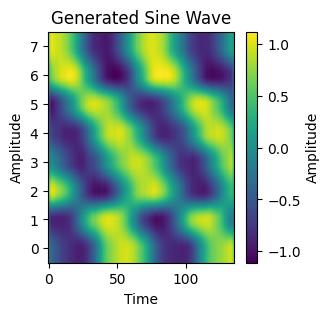

In [74]:
plot_sine_wave(dec_out[0].cpu().detach().numpy().T, title="Generated Sine Wave", xlabel="Time", ylabel="Amplitude")

In [75]:
# it sounds like produced an interesting wave pattern in the end with relatively small dataset.

# save transformer model
torch.save(wave_generator.state_dict(), "wave_generator.pth")